# Oops... Nothing Here..  So, you are on your own this time.

## Import Libraries 

In [1]:
!pip install wget
!pip install twython
import wget
import sys
print(sys.version)

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats.kde import gaussian_kde

#Data Packages
import math
import pandas
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk
from nltk.corpus import stopwords

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/reviews.zip")
# !unzip reviews.zip

## Load Data

In [0]:
#Read in from pandas
hotelDf = pandas.read_csv('reviews.csv')
hotelDf.columns=['filePath','hotelName','reviewColumn','ratingScore','groundTruth']

In [4]:
hotelDf.head()

,filePath,hotelName,reviewColumn,ratingScore,groundTruth
0,data/ca/297653/10089626/452253954.html,Hotel Divine Valley,"""We were 3 families that drove to Panchgani. W...",4,positive
1,data/ca/297653/10089626/531008588.html,Hotel Divine Valley,"""we were 5 ppl and a kid who stayed there..we ...",2,negative
2,data/ca/297653/10089626/581399063.html,Hotel Divine Valley,"""Villas are spacious and comfortable.. Clubhou...",5,positive
3,data/ca/297653/10243112/375397733.html,The Arowana Villa,"""Peaceful, relaxing, beautiful, cozy... I can'...",4,positive
4,data/ca/297653/10243112/478268268.html,The Arowana Villa,"""We 3 families stayed at Arowana Panchgani be...",4,positive


## Q1. Sentiment Analysis and Aggregation

### Q1(a)

In [0]:
def getNoOfRatings(hotelDf):
  ratings=hotelDf.groupby('hotelName').size().to_frame(name='no_of_reviews').reset_index()
  plt.hist(ratings.no_of_reviews.values, bins='auto', edgecolor='black', linewidth=1.2)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel('Number of Reviews')
  plt.ylabel('Number of Hotel')
  plt.title('Number of Reviews per Hotel')
  return ratings

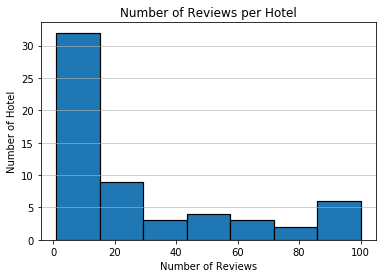

In [6]:
ratings=getNoOfRatings(hotelDf)  

In [7]:
ratings.describe() 

,no_of_reviews
count,59.000000
mean,27.694915
std,31.985586
min,1.000000
25%,5.000000
50%,12.000000
75%,44.500000
max,100.000000


In [0]:
# Use vader to evaluated sentiment of reviews
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pandas.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf
    
    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

In [9]:
reviews = hotelDf['reviewColumn'].values
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])
reviewDF.head()

100%|██████████| 1634/1634 [00:02<00:00, 767.31it/s]


,reviewCol,vader
0,"""We were 3 families that drove to Panchgani. W...",0.9961
1,"""we were 5 ppl and a kid who stayed there..we ...",0.3887
2,"""Villas are spacious and comfortable.. Clubhou...",0.8221
3,"""Peaceful, relaxing, beautiful, cozy... I can'...",0.9952
4,"""We 3 families stayed at Arowana Panchgani be...",0.9924


In [0]:
# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, k=500):
    reviews = reviewDF['reviewCol'].values
    
    stop = set(stopwords.words('english'))
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [11]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=500)
finaldf.head()

,hotelName,ratingScore,groundTruth,reviewCol,vader,hotel,good,food,room,rooms,place,stay,staff,view,panchgani,well,one,clean,service,also,nthe,family,nice,property,time,pool,great,resort,would,best,like,location,visit,area,valley,stayed,experience,breakfast,maintained,get,...,noise,trees,cuisine,including,expensive,spent,living,monsoon,bungalow,condition,hour,getaway,welcome,toilet,start,liked,week,set,hall,hills,decided,ordered,bustle,wish,taking,ud83d,already,everyone,issues,customer,whole,anyone,review,gave,adults,suggest,hustle,choose,mountains,surrounding
0,Hotel Divine Valley,4,positive,"""We were 3 families that drove to Panchgani. W...",0.9961,0,1,1,1,0,1,1,1,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hotel Divine Valley,2,negative,"""we were 5 ppl and a kid who stayed there..we ...",0.3887,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hotel Divine Valley,5,positive,"""Villas are spacious and comfortable.. Clubhou...",0.8221,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Arowana Villa,4,positive,"""Peaceful, relaxing, beautiful, cozy... I can'...",0.9952,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Arowana Villa,4,positive,"""We 3 families stayed at Arowana Panchgani be...",0.9924,0,1,0,0,0,1,0,1,1,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
#Extract a list of hotels
hotelNames = finaldf['hotelName'].unique()
hotelNames

array(['Hotel Divine Valley', 'The Arowana Villa', 'Ashirwad Bungalow',
       'Summer Plaza Resort', 'Mount View Heritage Hotel', 'Mount Castle',
       'OYO 10483 Hotel The Signature Crest', 'Blue Country Resort',
       'Hotel Millennium Park', 'Casa Bella Resort',
       'SaffronStays Verandah by the Valley', 'Bellevue Resort',
       'Hotel Summer Palace', 'Prospect Hotel',
       'Quick Getaway Clubs &amp; Resorts', 'The Loft', 'Miraya Hotel',
       'OYO 9566 Hotel JK Excellency', 'Hotel Blossom, Panchgani',
       'Animish Bungalow', 'Maitri Retreat', 'Umbrella Inn',
       'Hotel Gitanjali', 'Il Palazzo Hotel', 'Tranquil Treasure',
       'Royal Orbit', 'Lodge Suvidha', 'Magnus Caverns Resort',
       'Treebo Trend Prince Palace', 'Basilica Rediscover Serenity',
       'Mount View Executive, The Valley Resort', 'Terra Camp Resort',
       'Jivanta Hotel', 'Rahil Plaza', 'Brickland Hotel',
       'Sharda Arogya Dham', 'Hotel Mala&#39;s', 'The Dhanhills',
       'Exotic Home Sta

In [0]:
def getHotelRank(df, measure='ratingScore'):
    #Rank the hotel by ground truth rating score
    hotelRating = []
    for hotel in hotelNames:
        itemDf = df.loc[df['hotelName']==hotel]
        hotelRating.append([hotel,itemDf[measure].mean()])
    hotelRatingDfGt = pandas.DataFrame(hotelRating)
    hotelRatingDfGt.columns=['hotelName','avgRatingScore']
    hotelRatingDfGt = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0)
    return hotelRatingDfGt

In [14]:
hotelRatingDfGt = getHotelRank(finaldf)
hotelRatingDfGt.head()

,hotelName,avgRatingScore
29,Basilica Rediscover Serenity,5.000000
15,The Loft,5.000000
24,Tranquil Treasure,5.000000
32,Jivanta Hotel,5.000000
27,Magnus Caverns Resort,4.833333


In [15]:
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')
hotelRatingDfVd.head()

,hotelName,avgRatingScore
32,Jivanta Hotel,0.991800
24,Tranquil Treasure,0.979100
42,JenJon Holiday Homes Panchgani,0.977350
44,Mayur Agro Park,0.973267
10,SaffronStays Verandah by the Valley,0.964688


### Q1 (b)

In [16]:
hotelRatingDfGt = getHotelRank(finaldf)
hotelRatingDfGt.head()

,hotelName,avgRatingScore
29,Basilica Rediscover Serenity,5.000000
15,The Loft,5.000000
24,Tranquil Treasure,5.000000
32,Jivanta Hotel,5.000000
27,Magnus Caverns Resort,4.833333


In [17]:
hotelRatingDfVd = getHotelRank(finaldf, measure='vader')
hotelRatingDfVd.head()

,hotelName,avgRatingScore
32,Jivanta Hotel,0.991800
24,Tranquil Treasure,0.979100
42,JenJon Holiday Homes Panchgani,0.977350
44,Mayur Agro Park,0.973267
10,SaffronStays Verandah by the Valley,0.964688


In [18]:
for review in finaldf.loc[finaldf['hotelName']=='The Loft']['reviewCol']:
  print(review)

"Breathtakingly beautiful place to get away from the hustle bustle of  the concrete jungle....\nSuper host loving and generous very good rooms clean and hygenic...Very impressive \nAwesome food thoroughly enjoyed..\n\n
"Went with family and had a wonderful time. Overlooks the valley and lake. Rooms are well appointed and luxurious. Breakfast to die for ! The hosts go all out to make sure you have a great time. You won't be disappointed with this place.
"Clean property, excellent rooms. The food was exceptionally great,Pitambar the chef prepared some of the most exceptional food I've ever eaten. It's funny how you meet such exceptional talent in such remote cities.
"Visited during the monsoons which made it perfect for the breathtaking view this place has to offer.\nThe rooms were neatly kept and well desingned with a mini kitchen to facilitate all of our needs. We didn't bother cooking though cause the in house chef made the most delectable meals even entertaining our demands(tantrums!

In [0]:
analyser = SentimentIntensityAnalyzer()
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [20]:
sentiment_analyzer_scores("Breakfast to die for !")

Breakfast to die for !------------------ {'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'compound': -0.636}


**Answer 1(b)**: <br>
Two of the Five Hotels agree on the mention in Top-5. To investigate, one of the top-5 hotel- 'The Loft' as per the average ground truth rating as taken. The review for this hotel had tokens such as the 'die'. The vader lexicon rating for these tokens is very low (-2.9) [https://github.com/cjhutto/vaderSentiment/blob/master/vaderSentiment/vader_lexicon.txt]. This lead to an overall lower score for this hotel.

## Q2. Frequency Analysis

### Q2 (a)

In [0]:
#We are only intereseted in this three column for overall analysis
itemAnalysisDf = finaldf[['reviewCol','groundTruth','vader']]

In [0]:
def getTopK(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]: 
            counter.update([word.lower() 
                            for word 
                            in re.findall(r'\w+', review) 
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(k)
    return topk

In [23]:
topkGroundPos = getTopK(df=itemAnalysisDf, k=50, label_value='positive') 
topkGroundPos 

[('good', 1127),
 ('food', 1124),
 ('place', 936),
 ('panchgani', 587),
 ('view', 586),
 ('well', 529),
 ('clean', 470),
 ('family', 435),
 ('also', 430),
 ('one', 425),
 ('nice', 421),
 ('nthe', 420),
 ('service', 414),
 ('best', 373),
 ('property', 372),
 ('time', 371),
 ('great', 365),
 ('pool', 322),
 ('visit', 316),
 ('resort', 312),
 ('valley', 300),
 ('would', 296),
 ('like', 283),
 ('area', 266),
 ('stayed', 264),
 ('experience', 257),
 ('location', 253),
 ('beautiful', 240),
 ('maintained', 240),
 ('excellent', 239),
 ('really', 236),
 ('away', 220),
 ('breakfast', 216),
 ('market', 211),
 ('get', 208),
 ('restaurant', 202),
 ('helpful', 202),
 ('amazing', 191),
 ('swimming', 184),
 ('home', 181),
 ('table', 179),
 ('spacious', 178),
 ('around', 175),
 ('old', 170),
 ('quite', 167),
 ('big', 167),
 ('parsi', 166),
 ('small', 163),
 ('comfortable', 162),
 ('day', 160)]

In [24]:
topkGroundNeg = getTopK(df=itemAnalysisDf, k=50, label_value='negative') 
topkGroundNeg 

[('good', 400),
 ('food', 307),
 ('place', 250),
 ('one', 193),
 ('water', 183),
 ('service', 175),
 ('view', 150),
 ('nthe', 149),
 ('also', 146),
 ('pool', 141),
 ('panchgani', 138),
 ('like', 127),
 ('even', 126),
 ('location', 123),
 ('would', 122),
 ('property', 121),
 ('clean', 120),
 ('well', 115),
 ('time', 115),
 ('resort', 113),
 ('breakfast', 108),
 ('small', 107),
 ('bad', 105),
 ('night', 103),
 ('get', 102),
 ('bathroom', 100),
 ('area', 96),
 ('stayed', 93),
 ('experience', 93),
 ('booked', 93),
 ('day', 92),
 ('available', 91),
 ('better', 88),
 ('could', 88),
 ('people', 84),
 ('booking', 80),
 ('restaurant', 80),
 ('around', 80),
 ('money', 80),
 ('reception', 80),
 ('much', 78),
 ('maintained', 77),
 ('great', 77),
 ('dirty', 77),
 ('bed', 77),
 ('table', 75),
 ('old', 74),
 ('hot', 74),
 ('nice', 74),
 ('really', 73)]

In [25]:
finaldf.groundTruth.value_counts()

positive    1233
negative     401
Name: groundTruth, dtype: int64

**Answer 2(a)**: <br>

*   Topk or top50 positive and negative words were chosen based on the frequency in a positive and negative reviews respectively
*   The topK positive tokens such as the 'view', 'valley' suggests that it is a scenic place 
*   The token such as 'food' is decieving because they appear frequently in positive as well as negative reviews. However, off the total of 1233 positive reviews (91%), 'food' appears 1124 times and of the total of 401 negative reviews, 'food' appears 307 times (76%). Thus, it can be claimed that overall people like food at Pachgini
*   People liked 'parsi' point at this place
*   People are not happy with the 'water' at this place







###Q2 (b)

In [0]:
# Noun Phrase Extraction Support Functions
stopwords_g = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case... 
def normalise(word):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopwords_g)
    return accepted

# generator, create item once a time
def get_terms(tree):
    for leaf in leaves(tree):
        term = [normalise(w) for w,t in leaf if acceptable_word(w) ]
        # Phrase only
        if len(term)>1:
            yield term

In [0]:
# Flatten phrase lists to get tokens for analysis
def flatten(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        finalList.append(token.rstrip())
    return finalList

In [0]:
# Revise the previous dataframe transform function...
def newDataFrameTransformation(hotelDf, reviewDF, k=50):
    reviews = reviewDF['reviewCol'].values
    
    # Top-k frequent terms
    counter = Counter()
    for review in reviews:
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)        
    
    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten([word 
                                       for word 
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)
        
        
    #Prepare freqReviewDf
    freqReviewDf = pandas.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return topk, finaldf

In [0]:
# This grammar is described in the paper by S. N. Kim,
# T. Baldwin, and M.-Y. Kan.
# Evaluating n-gram based evaluation metrics for automatic
# keyphrase extraction.
# Technical report, University of Melbourne, Melbourne 2010.
grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
"""

In [0]:
# Part of Speech Tagging
# Google: https://en.wikipedia.org/wiki/Part-of-speech_tagging
tagger = PerceptronTagger()
pos_tag = tagger.tag
# Create phrase tree
chunker = nltk.RegexpParser(grammar)
# tree= chunker.parse(taggedToks)

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF, k=500)

In [32]:
topk_phrase 

[('hot water', 68),
 ('room servic', 51),
 ('swim pool', 50),
 ('main road', 49),
 ('good place', 47),
 ('good view', 40),
 ('il palazzo', 39),
 ('nthe room', 38),
 ('good food', 36),
 ('delux room', 35),
 ('great place', 30),
 ('good experi', 30),
 ('valley view', 29),
 ('valley view room', 29),
 ('tabl land', 29),
 ('prospect hotel', 29),
 ('panchgani market', 28),
 ('great time', 27),
 ('main market', 27),
 ('hotel staff', 27),
 ('nthe staff', 26),
 ('hira baug', 26),
 ('long weekend', 25),
 ('food qualiti', 25),
 ('parsi point', 25),
 ('nice place', 24),
 ('nthe food', 23),
 ('first time', 23),
 ('nthe hotel', 23),
 ('great view', 22),
 ('next day', 22),
 ('good room', 21),
 ('hotel room', 21),
 ('modern amen', 21),
 ('super delux room', 21),
 ('good hotel', 20),
 ('old world charm', 20),
 ('first floor', 19),
 ('tabl tenni', 19),
 ('hotel mala', 18),
 ('beauti view', 17),
 ('beauti place', 17),
 ('hotel prospect', 17),
 ('ground floor', 16),
 ('non veg', 16),
 ('night stay', 16),


In [0]:
# Revise the previous dataframe transform function...
def getTopKPhrase(df, k, label_value, label_column='groundTruth', operation=operator.eq, value_column='reviewCol'):
    counter = Counter()
    for review in df.loc[operation(df[label_column],label_value)][value_column]:  
            counter.update(flatten([word
                            for word 
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review)))) 
                            ]))
    topk = counter.most_common(k)
    return topk

In [34]:
topkPhraseGroundPos = getTopKPhrase(df=itemAnalysisDf, k=50, label_value='positive') 
topkPhraseGroundPos

[('il palazzo', 38),
 ('swim pool', 36),
 ('main road', 35),
 ('good place', 34),
 ('hot water', 31),
 ('good food', 31),
 ('nthe room', 29),
 ('prospect hotel', 29),
 ('great place', 28),
 ('good experi', 27),
 ('great time', 26),
 ('main market', 26),
 ('good view', 26),
 ('tabl land', 26),
 ('hira baug', 25),
 ('room servic', 24),
 ('panchgani market', 24),
 ('nthe staff', 23),
 ('nice place', 21),
 ('delux room', 21),
 ('parsi point', 21),
 ('valley view', 20),
 ('valley view room', 20),
 ('modern amen', 20),
 ('nthe food', 19),
 ('old world charm', 19),
 ('first time', 17),
 ('beauti place', 17),
 ('long weekend', 17),
 ('hotel prospect', 17),
 ('nthe hotel', 16),
 ('hotel room', 16),
 ('beauti view', 15),
 ('non veg', 15),
 ('famili friend', 15),
 ('hustl bustl', 15),
 ('strawberri farm', 15),
 ('good room', 14),
 ('great view', 14),
 ('nice view', 14),
 ('food qualiti', 14),
 ('spaciou room', 14),
 ('good staff', 14),
 ('super delux room', 14),
 ('amaz view', 14),
 ('live room',

In [35]:
topkPhraseGroundNeg = getTopKPhrase(df=itemAnalysisDf, k=50, label_value='negative') 
topkPhraseGroundNeg

[('hot water', 37),
 ('room servic', 27),
 ('swim pool', 14),
 ('next day', 14),
 ('good view', 14),
 ('delux room', 14),
 ('main road', 14),
 ('hotel staff', 14),
 ('good place', 13),
 ('food qualiti', 11),
 ('good thing', 10),
 ('bad experi', 10),
 ('good hotel', 10),
 ('tabl tenni', 9),
 ('valley view', 9),
 ('nthe room', 9),
 ('valley view room', 9),
 ('long weekend', 8),
 ('great view', 8),
 ('peak season', 8),
 ('travel organis', 8),
 ('first floor', 7),
 ('bed sheet', 7),
 ('good room', 7),
 ('nthe hotel', 7),
 ('super delux room', 7),
 ('play area', 6),
 ('first time', 6),
 ('air condition', 6),
 ('approach road', 6),
 ('carrom board', 5),
 ('door lock', 5),
 ('hotel room', 5),
 ('extra bed', 5),
 ('hotel manag', 5),
 ('small room', 5),
 ('good food', 5),
 ('hill station', 5),
 ('recept area', 5),
 ('premium suit', 5),
 ('good locat', 5),
 ('ravin hotel', 5),
 ('ground floor', 4),
 ('averag experi', 4),
 ('bath tub', 4),
 ('new room', 4),
 ('game room', 4),
 ('tt tabl', 4),
 ('

**Answer 2(b)**: <br>


*   'il plazzo' had highest frequency in positive reviews. Il Plazzo is in iteself a hotel name and it had maximum 100 reviews. Thus, term frequency based approach is biased towards/ dominated by the hotels with high reviews.
*   Similarily, 'swimmming pool' appeared frequently in positive reviews. This may be due to the where in one of the hotel with the highest review has a good swimming pool. However, this cannote be generalized to the city. 
*   Panchgini has a very good 'table land', 'parsi point', 'panchgini market' and 'hira baug' for tourists
*   The place has good 'strawberry farms'
*   Even though 'hot water appeared frequently in negative reviews, it also appeard almsot equally in the positive reviews. Thus, it cannot be concluded that hot water isn't good in the city. Same goes for the phrase 'room servic'









##Q3 Mutual Information

### Q3 (a)

In [0]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []      
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])]) 
    miScoredf = pandas.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [0]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=1500) 

In [38]:
len(topk)

1500

In [39]:
miScoredf = getMI(topk, finaldf)
miScoredf.head(50)

,Word,MI Score
226,dirty,0.040236
121,bad,0.037281
276,poor,0.035465
36,water,0.031018
504,worst,0.025540
590,horrible,0.023645
3,room,0.023550
286,working,0.022306
540,pathetic,0.020365
80,bathroom,0.019084


**Answer 3(a)**: <br>


*   Top 500 tokens cannot be used becuase there can be tokens with lower frequency but higher MI. Thus, finding threshold of the k such that the rank of top 50 MI remains the same
*   Negative terms had higher MI compared to the positive i.e a sign of presence of the negative terms in negative reviews as well as its absence in positive reviews
*   There is absense of local-specific terms such as 'valley', 'mountains', 'parsi' which appeared in the frequency based approach. This may be due to the case that such terms are not able to discren well between the positive or negative review i.e. these terms have their presence in positive and well as negative reviews

### Q3 (b)

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF, k=5000)

In [41]:
len(topk_phrase)

5000

In [42]:
miScoredf_phrase = getMI(topk_phrase, finaldf_phrase)
miScoredf_phrase.head(50) 

,Word,MI Score
161,bed sheet,0.006047
0,hot water,0.005557
1,room servic,0.005304
78,bad experi,0.004372
59,good thing,0.004205
15,prospect hotel,0.003646
82,peak season,0.003479
430,horror hous,0.003448
222,small room,0.002829
41,beauti place,0.002773


**Answer 3(b)**: <br>


*   Top 500 tokens of phrases cannot be used becuase there can be tokens with lower frequency but higher MI. Thus, finding threshold of the k such that the rank of top 50 MI remains the same
*   The phrases such as 'bed sheets', 'hot water', 'room servic' with highest MI does not tell whether it was used in a postive or negative context. This is due to the fact that MI is calculated over all the possible combinations of ground truth as well as the presense/absence of a phrase

##Q4 Pointwise Mutual Information

### Q4 (a)

In [0]:
# Simple example of getting pairwise mutual information of a term
def pmiCal(df, x):
    pmilist=[]
    for i in ['positive','negative']:
        for j in [0,1]:
            px = sum(df['groundTruth']==i)/len(df) #FRAC OF REVIEWS POS OR NEG IN DF
            py = sum(df[x]==j)/len(df) #FRAC OF REVIEWS WITH WORD x 
            pxy = len(df[(df['groundTruth']==i) & (df[x]==j)])/len(df)
            if px ==0 or py == 0: 
              pmi= -99 
            elif pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)/(px*py))
            else:
                pmi = math.log(pxy/(px*py))
            pmilist.append([i]+[j]+[px]+[py]+[pxy]+[pmi])
    pmidf = pandas.DataFrame(pmilist)
    pmidf.columns = ['x','y','px','py','pxy','pmi']
    return pmidf

In [0]:
def pmiIndivCal(df,x,gt, label_column='groundTruth'):
    px = sum(df[label_column]==gt)/len(df)
    py = sum(df[x]==1)/len(df)
    pxy = len(df[(df[label_column]==gt) & (df[x]==1)])/len(df)
    if px ==0 or py == 0:
        pmi= -99 
    elif pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)/(px*py))
    else:
        pmi = math.log(pxy/(px*py))
    return pmi

In [0]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, label_column='groundTruth', topk=topk):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe
    pmilist = []
    pmiposlist = []
    pmineglist = []
    for word in tqdm(topk):
        pmilist.append([word[0]]+[pmiCal(df,word[0])])
        pmiposlist.append([word[0]]+[pmiIndivCal(df,word[0],'positive',label_column)])
        pmineglist.append([word[0]]+[pmiIndivCal(df,word[0],'negative',label_column)])
    pmidf = pandas.DataFrame(pmilist)
    pmiposlist = pandas.DataFrame(pmiposlist)
    pmineglist = pandas.DataFrame(pmineglist)
    pmiposlist.columns = ['word','pmi']
    pmineglist.columns = ['word','pmi']
    pmidf.columns = ['word','pmi']
    return pmiposlist, pmineglist, pmidf

In [0]:
topk, finaldf = dataFrameTransformation(hotelDf, reviewDF, k=1500) 

In [47]:
len(topk)

1500

In [48]:
pmiposlist, pmineglist, pmidf = pmiForAllCal(finaldf)

100%|██████████| 1500/1500 [00:38<00:00, 39.10it/s]


In [49]:
pmiposlist.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
1094,log,0.281581
1251,heaven,0.281581
517,truly,0.281581
1356,skeptical,0.281581
921,outstanding,0.281581
397,faram,0.281581
1370,delicacies,0.281581
1395,impressed,0.281581
244,prospect,0.281581
1278,stroll,0.281581


In [50]:
pmineglist.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
871,confirmed,1.404825
1402,oyo,1.404825
790,u003e,1.404825
1394,unprofessional,1.404825
590,horrible,1.404825
973,badly,1.404825
1448,pillow,1.404825
504,worst,1.374053
680,rude,1.362265
920,terrible,1.340286


**Answer 4(a)**: <br>

*   Unlike MI, in PMI, it is feasible to check if the token is used positively or negatively in the the review 
*   The presence of the terms like 'insects', 'mosquitoes' indicate that the place is prone to insect bites thereby leading to a negavtive customer experience
*   The local-specific detail obtained in the positive PMI terms was negligible. However, there were names found in the positive PMI terms most likely indicating that the host's name   

###Q4 (b)

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF, k=100)

In [52]:
len(topk_phrase)

100

In [53]:
pmiposlist_phrase, pmineglist_phrase, pmidf_phrase = pmiForAllCal(finaldf_phrase,'groundTruth',topk_phrase)

100%|██████████| 100/100 [00:01<00:00, 57.04it/s]


In [54]:
pmiposlist_phrase.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
80,heritag hotel,0.281581
50,famili friend,0.281581
95,heritag properti,0.281581
41,beauti place,0.281581
91,qualiti time,0.281581
90,help staff,0.281581
42,hotel prospect,0.281581
52,strawberri farm,0.281581
62,spaciou room,0.281581
73,mount view heritag,0.281581


In [55]:
pmineglist_phrase.sort_values(by='pmi', ascending=0).head(50) 

,word,pmi
78,bad experi,1.271293
82,peak season,1.086371
59,good thing,1.068353
1,room servic,0.752500
19,hotel staff,0.711678
98,hotel manag,0.711678
0,hot water,0.711678
30,next day,0.711678
35,good hotel,0.657610
38,tabl tenni,0.657610


**Answer 4(b)**: <br>

*   The k in topkPhrase was tuned such that the resultant PMIs in top 50 are as distinct as possible and to include least negative PMIs
*   'strawberri farm', 'panchgini market', 'hira baugh', 'mapro gardern' are the local-specific places with postivie reviews. In fact, it is only PMI that the most renowned place 'mapro garden' was obtained. In general, reviews of the place are positive with good views
*   People had negative reviews associated with rainy season, indicating monsoon may not be the best time to visit this place.  
*   Overall, people were not happy with the 'hotel staff', 'hotel water'. However, this can he hotel-specific and may not be implied for the city.   

### Q4 (c)

In [0]:
topk_phrase, finaldf_phrase = newDataFrameTransformation(hotelDf, reviewDF, k=5000)

In [57]:
hotelRatingDfGt['hotelName'].values[0]

'Basilica Rediscover Serenity'

In [58]:
finaldf_phrase.loc[finaldf_phrase['hotelName']==hotelRatingDfGt['hotelName'].values[0]]

,hotelName,ratingScore,groundTruth,reviewCol,vader,hot water,room servic,swim pool,main road,good place,good view,il palazzo,nthe room,good food,delux room,great place,good experi,valley view,valley view room,tabl land,prospect hotel,panchgani market,great time,main market,hotel staff,nthe staff,hira baug,long weekend,food qualiti,parsi point,nice place,nthe food,first time,nthe hotel,great view,next day,good room,hotel room,modern amen,super delux room,...,love home,home parvanez,shahram wonder host,hotel mani time,strawberri festiv nthe food,mulberri jam,nbeauti properti,long stay,old friend place,open arm,owner parvaneh,wonder woman,lifelong friend prospect hotel,india sen,superb must,word hotel,place perfect landscap,cute cottag,littl housi,simpl restaur,sever chang,constant addit,everyon must visit,properti consist,differ size,small hillock,main market nfood,old british club,fantast parsi food nthey,small librari nthe cottag,clean ni,diwali vacat,heritag furnitur,food right,non veg food veg,non veg lover food,star hotel overal experi,long cover veranda,lush green lawn,reason nit
877,Basilica Rediscover Serenity,5,positive,"""Best hotel to stay in the area with perfect l...",0.9732,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
878,Basilica Rediscover Serenity,5,positive,"""Great modern rooms, amazing service at a good...",0.9761,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
879,Basilica Rediscover Serenity,5,positive,"""One of the best resorts in Panchgani!!! We ha...",0.9893,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
880,Basilica Rediscover Serenity,5,positive,"""Had stayed in this resort exclusively to prop...",0.4588,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
881,Basilica Rediscover Serenity,5,positive,"""When you plan your visit to Panchgani or Maha...",0.9605,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
pmiposlist_phrase_top, pmineglist_phrase_top, pmidf_phrase_top = pmiForAllCal(finaldf_phrase.loc[finaldf_phrase['hotelName']==hotelRatingDfGt['hotelName'].values[0]],'groundTruth',topk_phrase)

100%|██████████| 5000/5000 [01:06<00:00, 75.07it/s]


In [60]:
pmiposlist_phrase_top.sort_values(by='pmi', ascending=0).head(50) 

,word,pmi
128,reason price,0.0
596,memor one,0.0
449,complet packag,0.0
415,perfect getaway,0.0
650,amaz hospit,0.0
759,flat tyre,0.0
622,special thank,0.0
1220,person care,0.0
271,famili stay,0.0
1256,mr mateen,0.0


In [61]:
pmineglist_phrase_top.sort_values(by='pmi', ascending=0).head(50) 

,word,pmi
0,hot water,-99
3330,good featur,-99
3337,point room servic,-99
3336,travel desk,-99
3335,good tri local dish,-99
3334,sure everyon,-99
3333,morn person attent,-99
3332,lawn nfresh food nprompt servic,-99
3331,huge properti nclean pool,-99
3329,panchgani cool breez valley view open lawn minut,-99


In [62]:
len(topk)

1500

In [63]:
pmiposlist_top, pmineglist_top, pmidf_top = pmiForAllCal(finaldf.loc[finaldf['hotelName']==hotelRatingDfGt['hotelName'].values[0]],'groundTruth',topk)

100%|██████████| 1500/1500 [00:19<00:00, 78.34it/s]


In [0]:
df1=finaldf.loc[finaldf['hotelName']==hotelRatingDfGt['hotelName'].values[0]]

In [65]:
pmiCal(df1, 'hotel')

,x,y,px,py,pxy,pmi
0,positive,0,1.0,0.6,0.6,0.0
1,positive,1,1.0,0.4,0.4,0.0
2,negative,0,0.0,0.6,0.0,-99.0
3,negative,1,0.0,0.4,0.0,-99.0


In [66]:
pmiposlist_top.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
0,hotel,0.0
127,needs,0.0
110,hospitality,0.0
111,worth,0.0
118,want,0.0
123,perfect,0.0
361,thanks,0.0
598,ngood,0.0
709,attention,0.0
150,delicious,0.0


In [67]:
pmineglist_top.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
0,hotel,-99
997,helping,-99
1006,inr,-99
1005,drinks,-99
1004,carry,-99
1003,evenings,-99
1002,present,-99
1001,behind,-99
1000,august,-99
999,closed,-99


In [68]:
hotelRatingDfGt.tail()

,hotelName,avgRatingScore
51,Hotel Residency,2.586207
37,The Dhanhills,2.550000
56,Alliance Tents and Accommodations,1.750000
17,OYO 9566 Hotel JK Excellency,1.400000
2,Ashirwad Bungalow,1.000000


In [69]:
finaldf_phrase.loc[finaldf_phrase['hotelName']==hotelRatingDfGt.tail(2)['hotelName'].values[0]]

,hotelName,ratingScore,groundTruth,reviewCol,vader,hot water,room servic,swim pool,main road,good place,good view,il palazzo,nthe room,good food,delux room,great place,good experi,valley view,valley view room,tabl land,prospect hotel,panchgani market,great time,main market,hotel staff,nthe staff,hira baug,long weekend,food qualiti,parsi point,nice place,nthe food,first time,nthe hotel,great view,next day,good room,hotel room,modern amen,super delux room,...,love home,home parvanez,shahram wonder host,hotel mani time,strawberri festiv nthe food,mulberri jam,nbeauti properti,long stay,old friend place,open arm,owner parvaneh,wonder woman,lifelong friend prospect hotel,india sen,superb must,word hotel,place perfect landscap,cute cottag,littl housi,simpl restaur,sever chang,constant addit,everyon must visit,properti consist,differ size,small hillock,main market nfood,old british club,fantast parsi food nthey,small librari nthe cottag,clean ni,diwali vacat,heritag furnitur,food right,non veg food veg,non veg lover food,star hotel overal experi,long cover veranda,lush green lawn,reason nit
696,OYO 9566 Hotel JK Excellency,1,negative,"""We are senior citizens and my wife is diabeti...",-0.8838,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
697,OYO 9566 Hotel JK Excellency,1,negative,"""No DG back, staffs very arrogant, worst break...",-0.7623,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
698,OYO 9566 Hotel JK Excellency,3,negative,"""We stayed there for a day as we were heading ...",0.8689,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
699,OYO 9566 Hotel JK Excellency,1,negative,"""Terrible stay terrible I must say.\nNot recom...",-0.8860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
700,OYO 9566 Hotel JK Excellency,1,negative,"""We (me and my friend) had been there for one ...",-0.9587,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [70]:
pmiposlist_phrase_bot, pmineglist_phrase_bot, pmidf_phrase_bot = pmiForAllCal(finaldf_phrase.loc[finaldf_phrase['hotelName']==hotelRatingDfGt.tail(2)['hotelName'].values[0]],'groundTruth',topk_phrase)
pmiposlist_phrase_bot.sort_values(by='pmi', ascending=0).head(50)

100%|██████████| 5000/5000 [01:06<00:00, 75.59it/s]


,word,pmi
0,hot water,-99
3330,good featur,-99
3337,point room servic,-99
3336,travel desk,-99
3335,good tri local dish,-99
3334,sure everyon,-99
3333,morn person attent,-99
3332,lawn nfresh food nprompt servic,-99
3331,huge properti nclean pool,-99
3329,panchgani cool breez valley view open lawn minut,-99


In [71]:
pmineglist_phrase_bot.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
1175,continu knock,0.0
19,hotel staff,0.0
1176,seclud place,0.0
117,hill station,0.0
30,next day,0.0
915,hotel nwe,0.0
137,first experi,0.0
103,senior citizen,0.0
123,peac place,0.0
398,wi fi,0.0


In [72]:
pmiposlist_bot, pmineglist_bot, pmidf_bot = pmiForAllCal(finaldf.loc[finaldf['hotelName']==hotelRatingDfGt.tail(1)['hotelName'].values[0]],'groundTruth',topk)
pmiposlist_bot.sort_values(by='pmi', ascending=0).head(50)

100%|██████████| 1500/1500 [00:19<00:00, 77.52it/s]


,word,pmi
0,hotel,-99
997,helping,-99
1006,inr,-99
1005,drinks,-99
1004,carry,-99
1003,evenings,-99
1002,present,-99
1001,behind,-99
1000,august,-99
999,closed,-99


In [73]:
pmineglist_bot.sort_values(by='pmi', ascending=0).head(50)

,word,pmi
167,going,0.0
1021,bunglow,0.0
26,location,0.0
1019,dec,0.0
228,without,0.0
1328,taker,0.0
1329,bill,0.0
34,get,0.0
36,water,0.0
793,attitude,0.0


**Answer 4(c)**: <br>

*   To handle the case of px/py =0, the pmi is set of -99 to be able to discern the terms relevant to the top/bottom hotel reviews from the other terms 
*   From the phrase analysis, the phrases such as the 'reason price', 'amaz hospit', 'delici food', 'perfect locat' indicate the top most hotel- has resonable price, good food and hospitable staff
*   Since all the reviews of the best hotel were positive, no relevant negative pharases/ terms were obtained from the top hotel  
*   Since, the bottomost hotel has phrase such as 'hotel staff' and other terms such as the 'water', 'electricity' and bill, it indicated that the hotel staff were not good. Moreover, people had bad experince with water and electricity in this hotel 

## Q5 General Plots

### Q5 (a) Histogram



#### (a)


In [0]:
def getHistogram(measure, title):
    if measure=='both':
        x = [finaldf['ratingScore'].values/5] 
        y = [finaldf['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.title(title)
        plt.hist(x, bins, label='ground truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value") 
        plt.ylabel("Frequency") 
        plt.show()
    
    else:
        plt.hist(finaldf[measure].values)
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        fig = plt.gcf() 

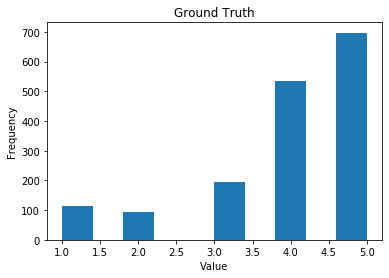

In [75]:
getHistogram('ratingScore', 'Ground Truth')


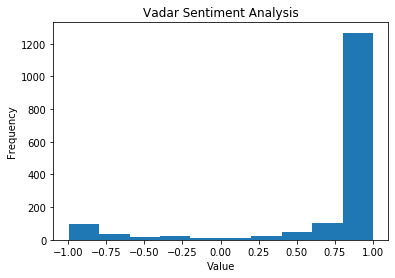

In [76]:
getHistogram('vader', 'Vadar Sentiment Analysis')

**Answer 5(a)**: <br>

*   The distribution of the ratings were similar for the ground truth and the vader compound scores. The ground truth rating (4/5) had a vader score of 1  
*   It was an unbalanced dataset with the majority of the ratings being positive. It was expected as the top 50 PMIs for the negative phrases included positive phrases with the negative PMIs

#### (b)


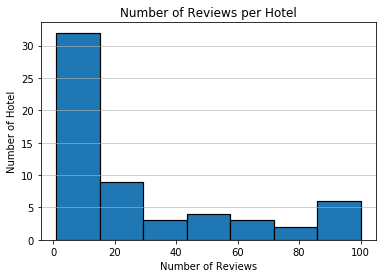

In [77]:
ratings=getNoOfRatings(hotelDf)

In [78]:
ratings.describe()

,no_of_reviews
count,59.000000
mean,27.694915
std,31.985586
min,1.000000
25%,5.000000
50%,12.000000
75%,44.500000
max,100.000000


**Answer 5(b)**: <br>

*   The maximum number of reviews were 100, this was expected as the maximum number of reviews per hotel was restricted to 100  
*   The data had in all reviews of 59 hotels with the majority of the hotels having less than 20 reviews 

### Q5 (b) Boxplots



#### (a)


In [79]:
#Plot top 5 side-by-side boxplot for top 5 ground truth rated hotel
tp5gthotel = hotelRatingDfGt.sort_values('avgRatingScore',ascending=0).head(5)
tp5gthotel['hotelName'].values

array(['Basilica Rediscover Serenity', 'The Loft', 'Tranquil Treasure',
       'Jivanta Hotel', 'Magnus Caverns Resort'], dtype=object)

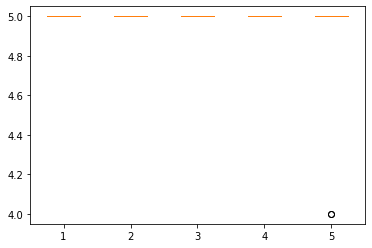

In [80]:
Basilica  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['ratingScore']
Loft = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['ratingScore']
Tranquil  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['ratingScore']
Jivanta  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['ratingScore']
Magnus  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['ratingScore']

data = [Basilica, Loft, Tranquil, Jivanta, Magnus]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

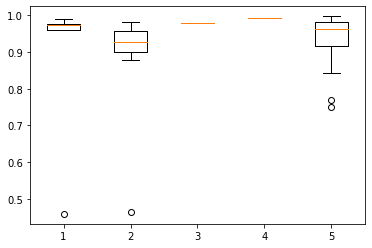

In [81]:
Basilica  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[0]]['vader']
Loft = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[1]]['vader']
Tranquil  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[2]]['vader']
Jivanta  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[3]]['vader']
Magnus  = finaldf.loc[finaldf['hotelName'] == tp5gthotel['hotelName'].values[4]]['vader']

data = [Basilica, Loft, Tranquil, Jivanta, Magnus]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

In [82]:
#Plot top 5 side-by-side boxplot for top 5 Vader rated hotel
tp5vdhotel = hotelRatingDfVd.sort_values('avgRatingScore',ascending=0).head(5)
tp5vdhotel['hotelName'].values

array(['Jivanta Hotel', 'Tranquil Treasure',
       'JenJon Holiday Homes Panchgani', 'Mayur Agro Park',
       'SaffronStays Verandah by the Valley'], dtype=object)

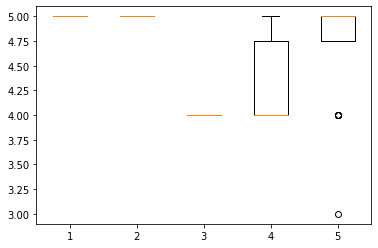

In [83]:
Jivanta  = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[0]]['ratingScore']
Tranquil  = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[1]]['ratingScore']
JenJon   = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[2]]['ratingScore']
Mayur   = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[3]]['ratingScore']
SaffronStays   = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[4]]['ratingScore']

data = [Jivanta, Tranquil, JenJon, Mayur, SaffronStays]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

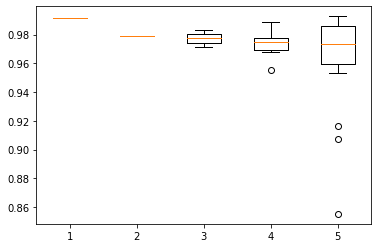

In [84]:
Jivanta  = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[0]]['vader']
Tranquil  = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[1]]['vader']
JenJon   = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[2]]['vader']
Mayur   = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[3]]['vader']
SaffronStays   = finaldf.loc[finaldf['hotelName'] == tp5vdhotel['hotelName'].values[4]]['vader']

data = [Jivanta, Tranquil, JenJon, Mayur, SaffronStays]
# multiple box plots on one figure
plt.figure()
plt.boxplot(data)
plt.show()

#### (b)


In [0]:
def getMeanVar(df, tp5gthotel, measure):
  tp5df=df.loc[df['hotelName'].isin(tp5gthotel['hotelName'].values)]#['vader']
  meandf=tp5df.groupby('hotelName')[measure].mean().to_frame(name='mean').reset_index()
  vardf=tp5df.groupby('hotelName')[measure].var().to_frame(name='variance').reset_index().fillna(0)
  meanvardf=meandf.merge(vardf, on='hotelName')
  return meanvardf

In [86]:
getMeanVar(finaldf, tp5gthotel, 'ratingScore')

,hotelName,mean,variance
0,Basilica Rediscover Serenity,5.000000,0.000000
1,Jivanta Hotel,5.000000,0.000000
2,Magnus Caverns Resort,4.833333,0.151515
3,The Loft,5.000000,0.000000
4,Tranquil Treasure,5.000000,0.000000


In [87]:
getMeanVar(finaldf, tp5gthotel, 'vader')

,hotelName,mean,variance
0,Basilica Rediscover Serenity,0.871580,0.053351
1,Jivanta Hotel,0.991800,0.000000
2,Magnus Caverns Resort,0.926467,0.007642
3,The Loft,0.869586,0.032895
4,Tranquil Treasure,0.979100,0.000000


**Answer 5(b)**: <br>

*   Boxplot is more informative compared to that of the mean and variance. It gives the information of the median, quartiles, spread and the range (minimum and maximum). The only data only covered in the boxplot is the mean, however, since the distribution is skewed, median is more information compared to the mean

#### (c)


### Q5 (c) Scatterplots and heatmaps



#### (a)


Text(0.5, 0, 'Vader Score')

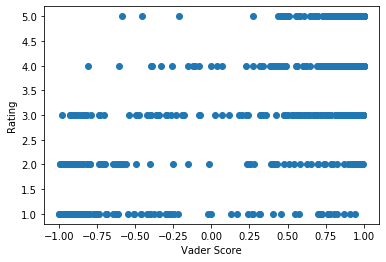

In [88]:
y = finaldf['ratingScore'].values
x = finaldf['vader'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Vader Score')

Text(0, 0.5, 'Rating')

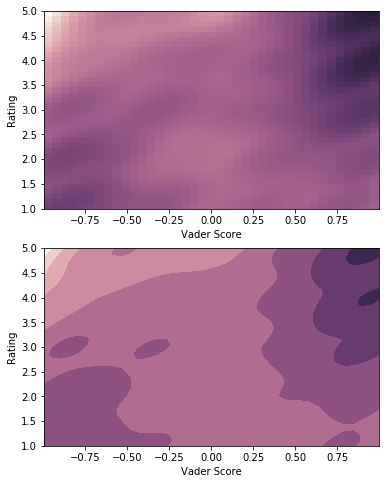

In [89]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Vader Score')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Vader Score')
ax2.set_ylabel('Rating')

**Answer 5(c)(a)**: <br>

*   Scatterplot gives the relation between the Vader score and the Star Ratings. For example, for the reviews with Star Rating of 5 majority of the vader score was 1. Similarily, majority of the reviews with the Startratings 1 had vader score of -1. The distribution of the vader score was more scattered for the reviews with star rating 3
*   Heatmap shows the strength of relationship between the vader score and star ratings. Stronger the relation i.e. denser the points for a given rating and vader score, the darker the heatmap gets around that region.         

#### (b)


Text(0.5, 0, 'Lenght of Review')

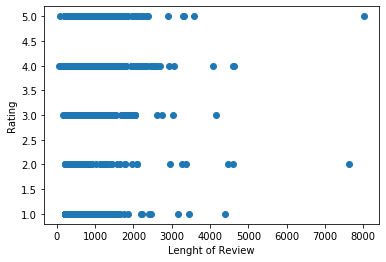

In [90]:
y = finaldf['ratingScore'].values
x= finaldf['reviewCol'].map(len).values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('Lenght of Review')

Text(0, 0.5, 'Rating')

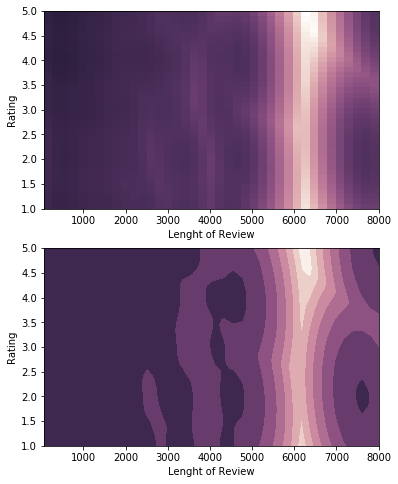

In [91]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Lenght of Review')
ax1.set_ylabel('Rating')

ax2.set_xlabel('Lenght of Review')
ax2.set_ylabel('Rating')

Text(0.5, 0, 'Lenght of Review')

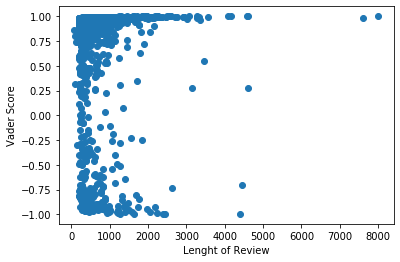

In [92]:
y = finaldf['vader'].values
x= finaldf['reviewCol'].map(len).values
plt.plot(x, y,"o")
plt.ylabel('Vader Score')
plt.xlabel('Lenght of Review')

Text(0, 0.5, 'Vader Score')

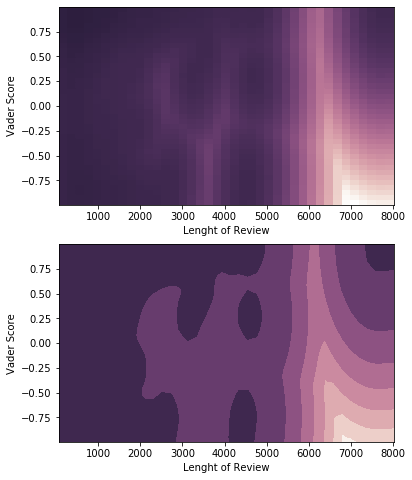

In [93]:
k = gaussian_kde(np.vstack([x, y]))
xi, yi = np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.pcolormesh(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)
ax2.contourf(xi, yi, np.log10(zi.reshape(xi.shape)), cmap=cmap)

ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax2.set_xlim(x.min(), x.max())
ax2.set_ylim(y.min(), y.max())

ax1.set_xlabel('Lenght of Review')
ax1.set_ylabel('Vader Score')

ax2.set_xlabel('Lenght of Review')
ax2.set_ylabel('Vader Score')

**Answer 5(c)(b)**: <br>

*   There is no trend in the length of reviews and the correspoding score/rating. Majority of the reviews had a length of less than 2000. The length of the reviews with vader score of 1 was comparatively higher thans that of the reviews with the vader score of -1

#### (c)


In [0]:
gtrat=ratings.merge(hotelRatingDfGt, on='hotelName')
reviewsRatings=gtrat.merge(hotelRatingDfVd, on='hotelName')
reviewsRatings.rename(columns={'avgRatingScore_x': 'avgRatingScore', 'avgRatingScore_y': 'avgVader', 'no_of_reviews': 'noOfReviews'}, inplace=True)

In [95]:
reviewsRatings.head()

,hotelName,noOfReviews,avgRatingScore,avgVader
0,Alliance Tents and Accommodations,4,1.75,-0.088625
1,Animish Bungalow,1,4.00,0.935300
2,Ashirwad Bungalow,1,1.00,-0.761600
3,Basilica Rediscover Serenity,5,5.00,0.871580
4,Bellevue Resort,25,4.36,0.771240


Text(0.5, 0, 'No of Review')

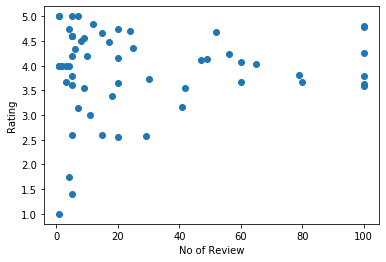

In [96]:
y = reviewsRatings['avgRatingScore'].values
x= reviewsRatings['noOfReviews'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('No of Review')

Text(0.5, 0, 'No of Review')

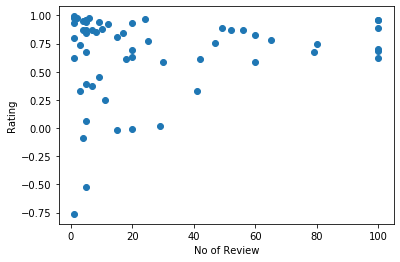

In [97]:
y = reviewsRatings['avgVader'].values
x= reviewsRatings['noOfReviews'].values
plt.plot(x, y,"o")
plt.ylabel('Rating')
plt.xlabel('No of Review')

**Answer 5(c)(c)**: <br>

*   There is no trend in the number of reviews and the correspoding score/rating. There were five hotels with 100 reviews signifying their popularity. Also, all these hotels had positive reviews.